<a href="https://colab.research.google.com/github/embarced/notebooks/blob/master/deep/tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Insurance: Predicting Crash Risk for prospective customers

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
tf.random.set_seed(42)

In [3]:
# notebook does not need GPU, but we could turn it on any time
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
import numpy as np
np.__version__

'1.19.5'

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [7]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve

In [8]:
from lrcurve import KerasLearningCurve

In [9]:
import seaborn as sns
sns.__version__

'0.11.1'

## Loading and exploring our data set
This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved in in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [10]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/embarced/notebooks/master/data/insurance-customers-1500.csv', sep=';')
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [11]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [12]:
vars = ['speed', 'age', 'miles']

In [13]:
sns.pairplot?

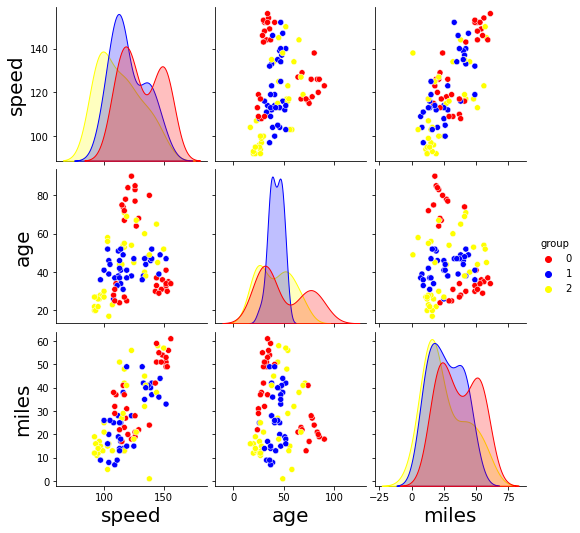

In [14]:
sample_df = df.sample(n=100, random_state=42)
sns.pairplot(sample_df, hue="group", kind="scatter", diag_kind="kde", vars=vars, palette={0: '#FF0000', 1: '#0000FF', 2: '#FFFF00'});

In [15]:
cm = df.corr()
cm.shape

(4, 4)

In [16]:
cm3 = cm.iloc[:3, :3]
cm3.shape

(3, 3)

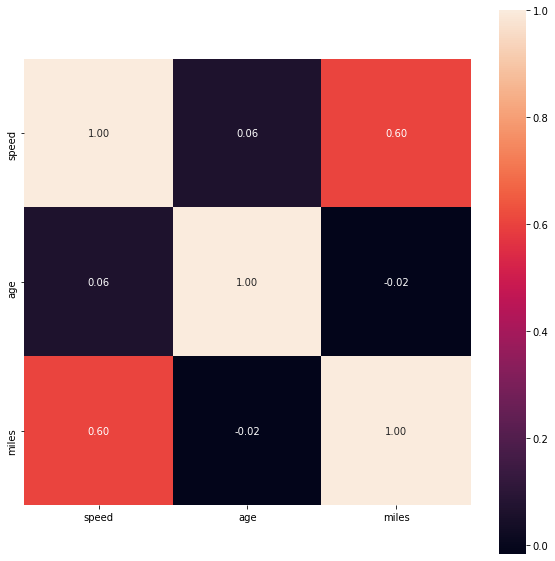

In [17]:
plt.figure(figsize=(10, 10))
hm = sns.heatmap(cm3,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                yticklabels=vars,
                xticklabels=vars)
# plt.savefig('cm.png', transparent=True)

# Hands-On 1: Create a network and train it
  * Which features do you want to use?
  * What do you want to predict?
  * What are the first and final layer?
  * What activation function?
  * What loss?


## Hint

In [18]:
y = df['group'].values
# add more columns to list to have fewer features to trainn on
X = df.drop(['group'], axis='columns').values
X.shape, y.shape

((1500, 3), (1500,))

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 3), (300, 3), (1200,), (300,))

In [20]:
# change according to number of input features
num_features = 3
num_categories = 3

In [21]:
from tensorflow.keras.layers import Input, Dense

model = tf.keras.Sequential()

# matches input
model.add(Input(name='input', shape=(num_features,)))

# whatever you want as hidden layer
model.add(Dense(name='hidden', units=500, activation='relu'))
model.add(Dense(name='hidden1', units=500, activation='relu'))
model.add(Dense(name='hidden2', units=500, activation='relu'))

# matches output
model.add(Dense(name='output', units=num_categories, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 500)               2000      
_________________________________________________________________
hidden1 (Dense)              (None, 500)               250500    
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
output (Dense)               (None, 3)                 1503      
Total params: 504,503
Trainable params: 504,503
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit?

In [23]:
%%time 

# BATCH_SIZE = 32
BATCH_SIZE = 100
EPOCHS = 500

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 1min 14s, sys: 4.84 s, total: 1min 19s
Wall time: 53.6 s


In [24]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

12/12 [==============================] - 0s 3ms/step - loss: 0.4663 - accuracy: 0.8342


(0.46633097529411316, 0.8341666460037231)

In [25]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

3/3 [==============================] - 0s 6ms/step - loss: 0.7000 - accuracy: 0.7400


(0.6999789476394653, 0.7400000095367432)

In [26]:
assert model.predict(np.array([[100, 48, 10]])).argmax() == 1

In [27]:
model.predict(np.array([[150, 30, 10]])).argmax()

0

# Hands-On 2: Regularization
  * regularize your model
  * how to make sure it generalizes?


## Hint

### An experimental approach:
- keep adding regularization to make validation and train scores come closer to each other
- this will come at the cost of train scores going down
- if both values start going down you have gone too far
- each experiment takes some time
- for larger datasets and more complex models some people start by overfitting on a subsample of the data (because it trains much faster)
  - then you can be sure you have an architecture that at least has the capacity to solve the problem
  - then keep adding regularizations
  - eventually try using the complete data
- if you want to use batch normalization place it between raw output of neuron and activation function    

In [46]:
from tensorflow.keras.layers import Input, Dense, Dropout, \
                                    BatchNormalization, Activation

dropout = 0.7
model = tf.keras.Sequential()

model.add(Input(name='input', shape=(num_features,)))

# reduce capacity by decreasing number of neurons
model.add(Dense(500, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(500, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='output', units=num_categories, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               2000      
_________________________________________________________________
activation_8 (Activation)    (None, 500)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 500)               2000      
_________________________________________________________________
dropout_8 (Dropout)          (None, 500)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_9 (Activation)    (None, 500)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 500)              

In [47]:
%%time

# reducing batch size might increase overfitting, 
# but might be necessary to reduce memory requirements 
BATCH_SIZE = 32

# reduce this based on what you see in the training history
EPOCHS = 250
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    # validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 1min, sys: 4.99 s, total: 1min 5s
Wall time: 1min 22s


In [48]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

38/38 [==============================] - 0s 2ms/step - loss: 0.5461 - accuracy: 0.7967


(0.5460814237594604, 0.79666668176651)

In [49]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

10/10 [==============================] - 0s 2ms/step - loss: 0.5572 - accuracy: 0.7900


(0.5572313666343689, 0.7900000214576721)

## Only 2 inputs

In [77]:
y = df['group'].values
# add more columns to list to have fewer features to trainn on
X = df.drop(['group', 'miles'], axis='columns').values
X.shape, y.shape

((1500, 2), (1500,))

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 2), (300, 2), (1200,), (300,))

In [52]:
# change according to number of input features
num_features = 2
num_categories = 3

In [53]:
from tensorflow.keras.layers import Input, Dense

model = tf.keras.Sequential()

# matches input
model.add(Input(name='input', shape=(num_features,)))

# whatever you want as hidden layer
model.add(Dense(name='hidden', units=500, activation='relu'))
model.add(Dense(name='hidden1', units=500, activation='relu'))
model.add(Dense(name='hidden2', units=500, activation='relu'))

# matches output
model.add(Dense(name='output', units=num_categories, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 500)               1500      
_________________________________________________________________
hidden1 (Dense)              (None, 500)               250500    
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
output (Dense)               (None, 3)                 1503      
Total params: 504,003
Trainable params: 504,003
Non-trainable params: 0
_________________________________________________________________


In [54]:
%%time

# reducing batch size might increase overfitting, 
# but might be necessary to reduce memory requirements 
BATCH_SIZE = 32

# reduce this based on what you see in the training history
EPOCHS = 250
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    # validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 1min 15s, sys: 6.18 s, total: 1min 21s
Wall time: 53 s


In [55]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

38/38 [==============================] - 0s 2ms/step - loss: 0.7569 - accuracy: 0.6892


(0.7568683624267578, 0.6891666650772095)

In [56]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

10/10 [==============================] - 0s 2ms/step - loss: 0.7520 - accuracy: 0.6833


(0.7520431876182556, 0.6833333373069763)

In [57]:
!pip install colour

In [58]:
# %config InlineBackend.figure_format = 'svg'

In [61]:
#@title Hidden code for plotting of decision boundaries taken from dtreeviz
# copied and adapted from
# https://github.com/parrt/dtreeviz/blob/class-boundary-viz/dtreeviz/classifiers.py
# need to use lib after changes have been merged

import numpy as np
import pandas as pd

import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from colour import Color
from PIL import ImageColor

YELLOW = '#fefecd'
GREEN = '#cfe2d4'
DARKBLUE = '#313695'
BLUE = '#4575b4'
DARKGREEN = '#006400'
LIGHTORANGE = '#fee090'
LIGHTBLUE = '#a6bddb'
GREY = '#444443'
WEDGE_COLOR = GREY
CATEGORICAL_SPLIT_LEFT= '#FFC300'
CATEGORICAL_SPLIT_RIGHT = BLUE

HIGHLIGHT_COLOR = '#D67C03'

color_blind_friendly_colors = [
    None,  # 0 classes
    None,  # 1 class
    ['#FEFEBB', '#a1dab4'],  # 2 classes
    ['#FEFEBB', '#D9E6F5', '#a1dab4'],  # 3 classes
    ['#FEFEBB', '#D9E6F5', '#a1dab4', LIGHTORANGE],  # 4
    ['#FEFEBB', '#D9E6F5', '#a1dab4', '#41b6c4', LIGHTORANGE],  # 5
    ['#FEFEBB', '#c7e9b4', '#41b6c4', '#2c7fb8', LIGHTORANGE, '#f46d43'],  # 6
    ['#FEFEBB', '#c7e9b4', '#7fcdbb', '#41b6c4', '#225ea8', '#fdae61', '#f46d43'],  # 7
    ['#FEFEBB', '#edf8b1', '#c7e9b4', '#7fcdbb', '#1d91c0', '#225ea8', '#fdae61', '#f46d43'],  # 8
    ['#FEFEBB', '#c7e9b4', '#41b6c4', '#74add1', BLUE, DARKBLUE, LIGHTORANGE, '#fdae61', '#f46d43'],  # 9
    ['#FEFEBB', '#c7e9b4', '#41b6c4', '#74add1', BLUE, DARKBLUE, LIGHTORANGE, '#fdae61', '#f46d43', '#d73027']  # 10
]

COLORS = {'scatter_edge': GREY,
          'scatter_marker': BLUE,
          'scatter_marker_alpha': 0.7,
          'class_boundary' : GREY,
          'warning' : '#E9130D',
          'tile_alpha':0.8,            # square tiling in clfviz to show probabilities
          'tesselation_alpha': 0.3,    # rectangular regions for decision tree feature space partitioning
          'tesselation_alpha_3D': 0.5,
          'split_line': GREY,
          'mean_line': '#f46d43',
          'axis_label': GREY,
          'title': GREY,
          'legend_title': GREY,
          'legend_edge': GREY,
          'edge': GREY,
          'color_map_min': '#c7e9b4',
          'color_map_max': '#081d58',
          'classes': color_blind_friendly_colors,
          'rect_edge': GREY,
          'text': GREY,
          'highlight': HIGHLIGHT_COLOR,
          'wedge': WEDGE_COLOR,
          'text_wedge': WEDGE_COLOR,
          'arrow': GREY,
          'node_label': GREY,
          'tick_label': GREY,
          'leaf_label': GREY,
          'pie': GREY,
          'hist_bar': LIGHTBLUE,
          'categorical_split_left': CATEGORICAL_SPLIT_LEFT,
          'categorical_split_right': CATEGORICAL_SPLIT_RIGHT
          }


def adjust_colors(colors):
    if colors is None:
        return COLORS
    return dict(COLORS, **colors)

import numpy as np
import pandas as pd

import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from colour import Color
from PIL import ImageColor

def clfviz_bivar(model, X:np.ndarray, y:np.ndarray,
                 ntiles=50, tile_fraction=.9,
                 binary_threshold=0.5,
                 show=['instances','boundaries','probabilities','misclassified'], # also 'legend'
                 feature_names=None, target_name=None, class_names=None,
                 markers=None,
                 boundary_marker='o', boundary_markersize=.8,
                 fontsize=9, fontname="Arial",
                 dot_w=25, colors:dict=None,
                 ax=None) -> None:
    """
    See comment and parameter descriptions for clfviz() above.
    """
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    if len(X.shape)==1 or (len(X.shape)==2 and X.shape[1]!=2) or len(X.shape)>2:
        raise ValueError(f"Expecting 2D data not {X.shape}")

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))

    # Created grid over the range of x1 and x2 variables, get probabilities, predictions
    grid_points, grid_proba, grid_pred_as_matrix, w, x_, class_X, class_values = \
        _compute_tiling(model, X, y, binary_threshold, ntiles, tile_fraction)

    x_proba = _predict_proba(model, X)
    if len(np.unique(y)) == 2:  # is k=2 binary?
        X_pred = np.where(x_proba[:, 1] >= binary_threshold, 1, 0)
    else:
        X_pred = np.argmax(x_proba, axis=1)  # TODO: assumes classes are 0..k-1
    class_X_pred = [X_pred[y == cl] for cl in class_values]

    if markers is None:
        markers = ['o']*len(class_X)

    colors = adjust_colors(colors)

    class_values = np.unique(y) # returns sorted

    # Get class to color map for probabilities and predictions
    color_map, grid_pred_colors, grid_proba_colors = \
        _get_grid_colors(grid_proba, grid_pred_as_matrix, class_values, colors)

    # Draw probabilities or class prediction grid
    facecolors = grid_proba_colors if 'probabilities' in show else grid_pred_colors
    _draw_tiles(ax, grid_points, facecolors, colors['tile_alpha'], x_, w)

    # Get grid with class predictions with coordinates (x,y)
    # e.g., y_pred[0,0] is lower left pixel and y_pred[5,5] is top-right pixel
    # for npoints=5
    grid_pred_as_matrix = grid_pred_as_matrix.reshape(ntiles, ntiles)

    if 'boundaries' in show:
        _draw_boundary_edges(ax, grid_points, grid_pred_as_matrix,
                             boundary_marker, boundary_markersize,
                             colors, w, x_)

    # Draw the X instances circles
    if 'instances' in show:
        for i, x_ in enumerate(class_X):
            if 'misclassified' in show:
                # Show correctly classified markers
                good_x = x_[class_X_pred[i] == class_values[i],:]
                ax.scatter(good_x[:, 0], good_x[:, 1],
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=colors['scatter_marker_alpha'],
                           edgecolors=colors['scatter_edge'],
                           lw=.5)
                # Show misclassified markers (can't have alpha per marker so do in 2 calls)
                bad_x = x_[class_X_pred[i] != class_values[i],:]
                ax.scatter(bad_x[:, 0], bad_x[:, 1],
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=1.0,
                           edgecolors=colors['warning'],
                           lw=.5)
            else:
                ax.scatter(x_[:, 0], x_[:, 1],
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=colors['scatter_marker_alpha'],
                           edgecolors=colors['scatter_edge'],
                           lw=.5)

    if feature_names is not None:
        ax.set_xlabel(f"{feature_names[0]}", fontsize=fontsize, fontname=fontname, color=colors['axis_label'])
        ax.set_ylabel(f"{feature_names[1]}", fontsize=fontsize, fontname=fontname, color=colors['axis_label'])

    if 'legend' in show:
        class_names = utils._normalize_class_names(class_names, nclasses=len(class_values))
        add_classifier_legend(ax, class_names, class_values, color_map, target_name, colors)

    ax.tick_params(axis='both', which='major', width=.3, labelcolor=colors['tick_label'],
                   labelsize=fontsize)
    for tick in ax.get_xticklabels():
        tick.set_fontname(fontname)
    for tick in ax.get_yticklabels():
        tick.set_fontname(fontname)
    ax.spines['top'].set_visible(False)  # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)

def _compute_tiling(model, X:np.ndarray, y:np.ndarray, binary_threshold,
                    ntiles, tile_fraction):
    """
    Create grid over the range of x1 and x2 variables; use the model to
    compute the probabilities with model.predict_proba(), which will work with sklearn
    and, I think, XGBoost. Later we will have to figure out how to get probabilities
    out of the other models we support.

    The predictions are computed simply by picking the argmax of probabilities, which
    assumes classes are 0..k-1. TODO: update to allow disjoint integer class values

    For k=2 binary classifications, there is no way to set the threshold and so
    a threshold of 0.5 is implicitly chosen by argmax.

    This returns all of the details needed to plot the tiles. The coordinates of
    the grid are a linear space from min to max of each variable, inclusively.
    So if the range is 1..5 and we want 5 tiles, then the width of each tile is 1.
    We get a tile at each position. When we are drawing, the position is taken as
    the center of the tile. In this case, the grid points would be centered over
    1,2,3,4, and 5.
    """
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    X1 = X[:, 0]
    X2 = X[:, 1]
    x1r = max(X1) - min(X1)
    x2r = max(X2) - min(X2)
    border1 = x1r*0.05 # make a 5% border
    border2 = x2r*0.05
    x1range = (min(X1)-border1, max(X1)+border1)
    x2range = (min(X2)-border2, max(X2)+border2)
    w = (x1r+2*border1) / (ntiles-1)
    h = (x2r+2*border2) / (ntiles-1)
    w *= tile_fraction
    h *= tile_fraction

    grid_points = []  # a list of coordinate pairs for the grid
    # Iterate through v1 (x-axis) most quickly then v2 (y-axis)
    for iv2, v2 in enumerate(np.linspace(*x2range, num=ntiles, endpoint=True)):
        for iv1, v1 in enumerate(np.linspace(*x1range, num=ntiles, endpoint=True)):
            grid_points.append([v1, v2])
    grid_points = np.array(grid_points)

    class_values = np.unique(y)
    class_X = [X[y == cl] for cl in class_values]

    grid_proba = _predict_proba(model, grid_points)

    if len(np.unique(y))==2: # is k=2 binary?
        grid_pred = np.where(grid_proba[:,1]>=binary_threshold,1,0)
    else:
        grid_pred = np.argmax(grid_proba, axis=1) # TODO: assumes classes are 0..k-1

    return grid_points, grid_proba, grid_pred, w, h, class_X, class_values


def _get_grid_colors(grid_proba, grid_pred, class_values, colors):
    """
    For the grid locations, return a list of colors, one per location
    indicating the class color.  To compute the probability color,
    we want to simulate overlaying regions from multiple trees onto
    the two-dimensional feature space using alpha to shade the colors.
    Instead, compute the color for each tile by combining the class colors
    according to their probabilities. If class 1 has probability .3 and class 2
    has probability .7, multiply the color ((R,G,B) color vector) associated
    with class 1 by .3 and the color vector associated with class 2 by .7 then
    add together. This gives a weighted color vector for each tile associated with
    the class probabilities. This gives the exact same effect as alpha channels,
    but transparent colors screwed up plotting the instance circles on top; they
    got washed out. This gives us more control and we can use alpha=1.
    """
    nclasses = len(class_values)
    class_colors = np.array(colors['classes'][nclasses])

    grid_pred_colors = class_colors[grid_pred] # color for each prediction in grid

    color_map = {v: class_colors[i] for i, v in enumerate(class_values)}
    # multiply each probability vector times rgb color for each class then add
    # together to get weighted color
    rgb = np.array([ImageColor.getcolor(c, mode="RGB") for c in class_colors])
    grid_proba_colors = grid_proba @ rgb
    grid_proba_colors /= 255  # get in [0..1]
    grid_proba_colors = [Color(rgb=c).hex for c in grid_proba_colors]
    return color_map, grid_pred_colors, grid_proba_colors


def _draw_tiles(ax, grid_points, facecolors, tile_alpha, h, w):
    boxes = []
    for i, (v1, v2) in enumerate(grid_points):
        # center a box over (v1,v2) grid location
        rect = patches.Rectangle((v1 - w / 2, v2 - h / 2), w, h, angle=0.0, linewidth=0,
                                 facecolor=facecolors[i], alpha=tile_alpha)
        boxes.append(rect)
    # Adding collection is MUCH faster than repeated add_patch()
    ax.add_collection(PatchCollection(boxes, match_original=True))


def _draw_boundary_edges(ax, grid_points, grid_pred_as_matrix, boundary_marker, boundary_markersize,
                         colors, w, h):
    ntiles = grid_pred_as_matrix.shape[0]

    # find transitions from one class to the other moving horizontally
    dx = np.diff(grid_pred_as_matrix, axis=1)
    dx = np.abs(dx)
    # put a zero col vector on the left to restore size
    dx = np.hstack([np.zeros((ntiles, 1)), dx])

    # find transitions moving vertically, bottom to top (grid matrix is flipped vertically btw)
    dy = np.diff(grid_pred_as_matrix, axis=0)
    dy = np.abs(dy)
    # put a zero row vector on the top to restore size
    dy = np.vstack([np.zeros((1, ntiles)), dy])

    dx_edge_idx = np.where(dx.reshape(-1)) # what are the indexes of dx class transitions?
    dy_edge_idx = np.where(dy.reshape(-1)) # what are the indexes of dy class transitions?
    dx_edges = grid_points[dx_edge_idx]    # get v1,v2 coordinates of left-to-right transitions
    dy_edges = grid_points[dy_edge_idx]    # get v1,v2 coordinates of bottom-to-top transitions

    # Plot the boundary markers in between tiles; e.g., shift dx stuff to the left half a tile
    ax.plot(dx_edges[:, 0] - w / 2, dx_edges[:, 1], boundary_marker,
            markersize=boundary_markersize, c=colors['class_boundary'], alpha=1.0)
    ax.plot(dy_edges[:, 0], dy_edges[:, 1] - h / 2, boundary_marker,
            markersize=boundary_markersize, c=colors['class_boundary'], alpha=1.0)

def _predict_proba(model, X):
    """
    This is where we figure out how to get a matrix of k probabilities for a k-class
    classification problem.  It works with any model that answers predict_proba()
    but we can add special cases such as Keras, that has deprecated that method.
    """
    if len(X.shape)==1:
        X = X.reshape(-1,1)
    # Keras wants predict not predict_proba and still gives probabilities
    if model.__class__.__module__.startswith('tensorflow.python.keras') or \
    model.__class__.__module__.startswith('keras'):
        proba = model.predict(X)
        if proba.shape[1]==1:
            proba = np.clip(proba, 0, 1)
            proba = np.hstack([1-proba,proba]) # get prob y=0, y=1 nx2 matrix like sklearn
        return proba

    # sklearn etc...
    return model.predict_proba(X)


In [78]:
def plot_decision_boundaries(model, X, y_true):
  _, ax = plt.subplots(figsize=(8,4), dpi=300)

  clfviz_bivar(
              model, X, y_true, 
             show=['instances', 'boundaries', 'probabilities', 'misclassified'],
             markers=['^','D', 'v'],
             ntiles=50, 
             ax=ax,
             tile_fraction=1.0, 
             boundary_markersize=1.0,
             feature_names=['Speed', 'Age'],
             colors={'class_boundary': 'black',
                     'tile_alpha': 0.5,
                     'warning' : 'yellow',
                     'classes':
                         [None,  # 0 classes
                          None,  # 1 class
                          None,  # 2 class
                          ['#FF0000', '#0000FF', '#FFFF00'],  # 3 classes
                          ]})

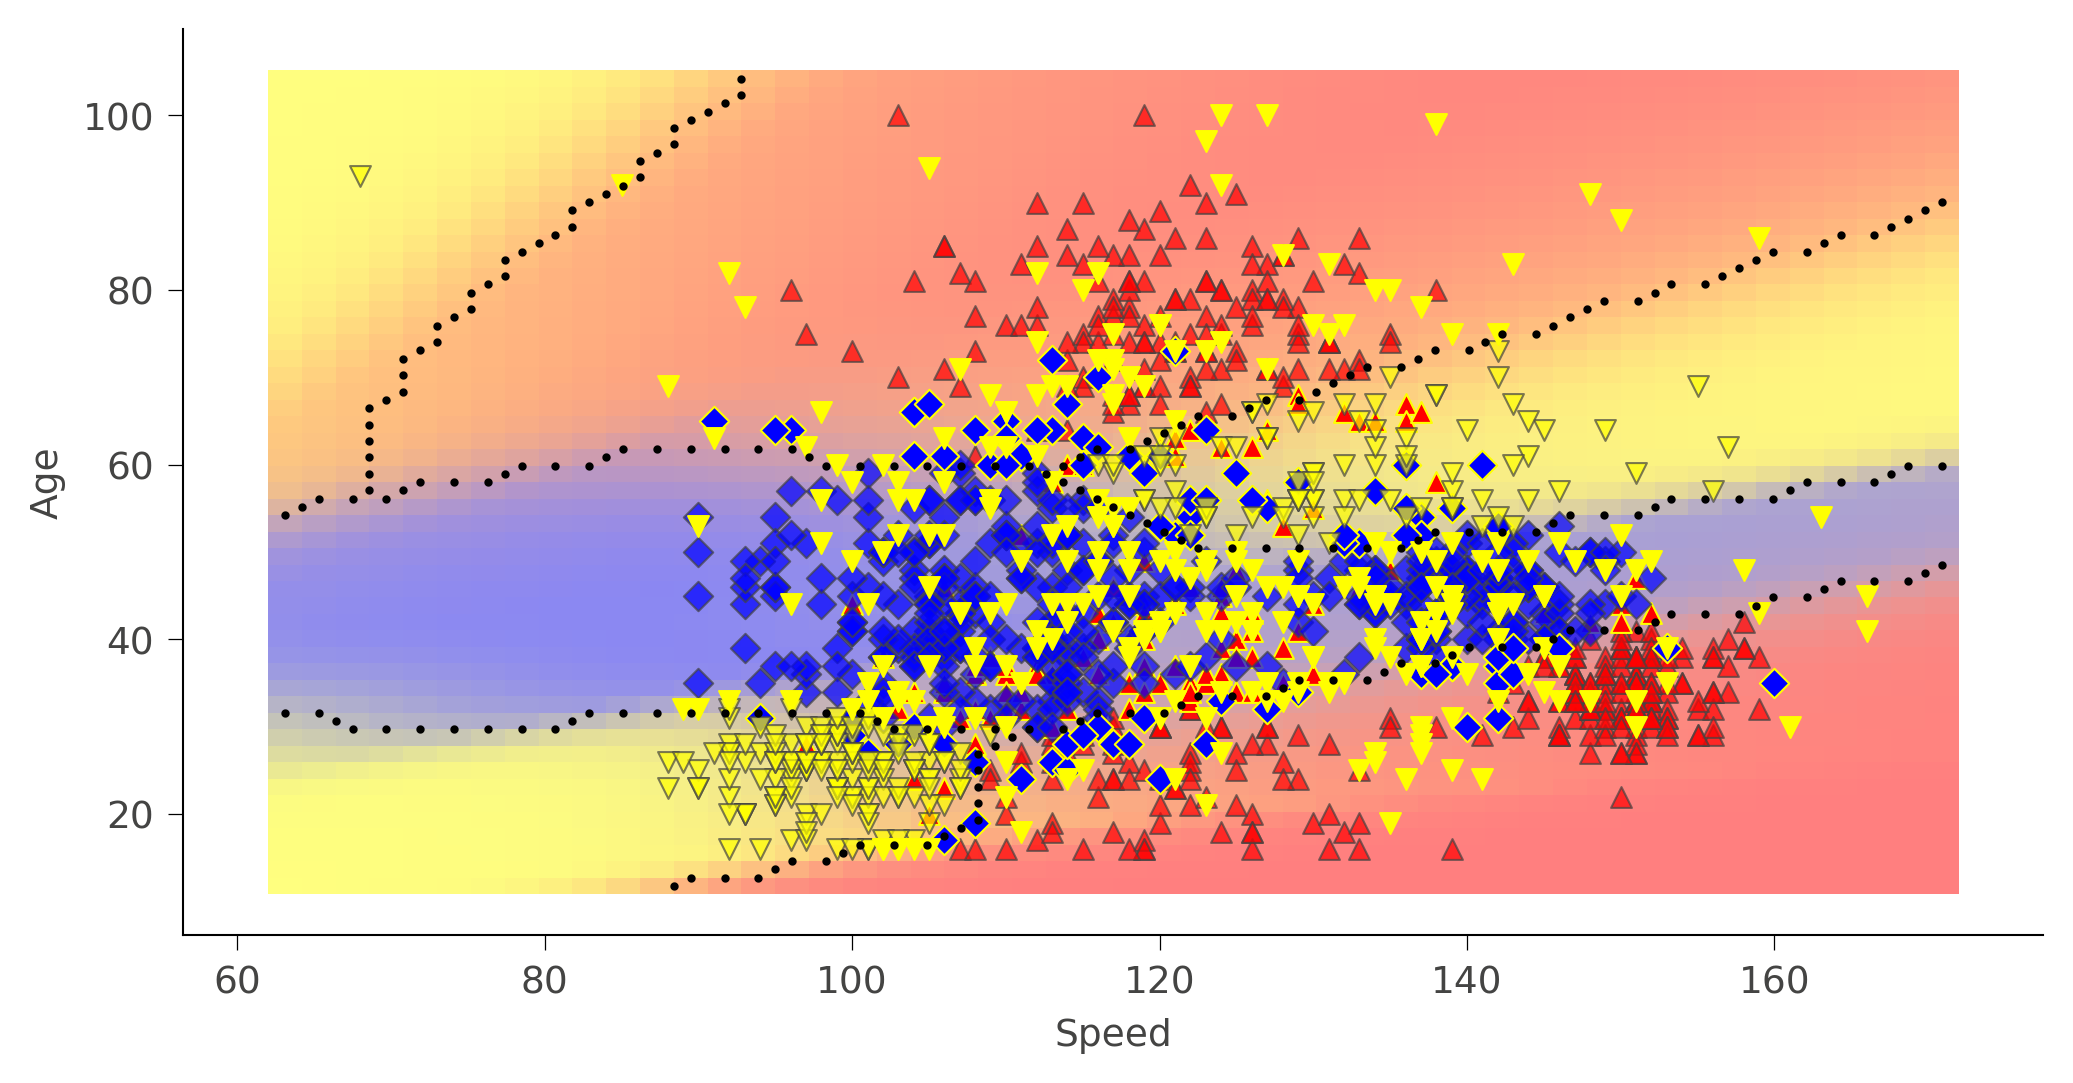

In [79]:
plot_decision_boundaries(model, X, y)